In [140]:
from scipy import misc
from scipy.fftpack import dct, idct
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [211]:
img = misc.face()
img = np.array(Image.fromarray(img).convert('L'))

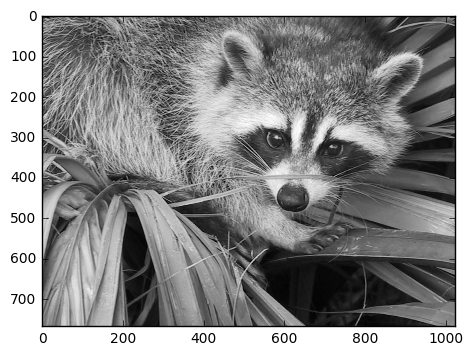

In [212]:
plt.imshow(img, cmap='gray')

# JPEG implementation
## 1. Divide into non-overlapping 8x8 blocks

In [213]:
# Bring image intensity range to [-128, 127] from [0, 255]
img = img - 128 * np.ones(img.shape)

In [214]:
block_size = 8

In [215]:
blocks = []
x_range = range(0, img.shape[0]+1, block_size)
y_range = range(0, img.shape[1]+1, block_size)
for i, _ in enumerate(x_range[:-1]):
    for j, _ in enumerate(y_range[:-1]):
        block = img[x_range[i]:x_range[i+1], y_range[j]:y_range[j+1]]
        blocks.append(block)

In [216]:
blocks[0]

array([[-12.,   5.,  21.,  23.,  23.,  25.,  26.,  23.],
       [-42., -21.,  -2.,   5.,   9.,  17.,  21.,  20.],
       [-58., -37., -16.,  -9.,  -5.,   0.,   1.,  -2.],
       [-48., -32., -16., -10.,  -5.,  -3.,  -9., -18.],
       [-27., -16.,  -6.,   2.,  12.,  17.,  11.,  -2.],
       [ -4.,   0.,   2.,   8.,  22.,  35.,  35.,  27.],
       [-19., -18., -20., -19.,  -5.,  17.,  31.,  35.],
       [-59., -58., -61., -61., -46., -15.,  15.,  29.]])

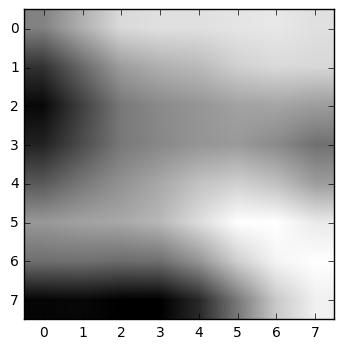

In [217]:
# Visualize one block
plt.imshow(blocks[0], cmap='gray')

## 2. Compute the DCT of each block

In [218]:
dct_blocks = [dct(block, norm='ortho') for block in blocks] 

In [219]:
dct_blocks = [[[int(round(value)) for value in row] for row in block] for block in dct_blocks]

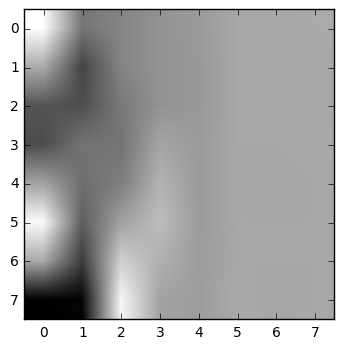

In [220]:
# Visualize transformed block
plt.imshow(dct_blocks[0], cmap='gray')

## 3. Quantization

In [221]:
quantization_matrix = np.array(
                       [[52, 55, 61, 66, 70, 61, 64, 73],
                       [63, 59, 66, 90, 109, 85, 69, 72],
                       [62, 59, 68, 113, 144, 104, 66, 73],
                       [63, 58, 71, 122, 154, 106, 70, 69],
                       [67, 61, 68, 104, 126, 88, 68, 70],
                       [79, 65, 60, 70, 77, 63, 58, 75],
                       [85, 71, 64, 59, 55, 61, 65, 83],
                       [87, 79, 69, 68, 65, 76, 78, 94]])

In [222]:
quantized_blocks = [block / quantization_matrix for block in dct_blocks]

In [245]:
quantized_blocks[0]

array([[ 0, -1, -1, -1, -1,  0,  0,  0],
       [ 0, -1, -1, -1, -1,  0,  0,  0],
       [-1, -1, -1, -1, -1,  0,  0,  0],
       [-1, -1, -1, -1, -1,  0,  0,  0],
       [-1, -1, -1,  0, -1,  0, -1,  0],
       [ 0, -1, -1,  0, -1,  0,  0,  0],
       [ 0, -1,  0,  0, -1,  0,  0,  0],
       [-2, -2,  0, -1, -1,  0, -1,  0]])

## 4. Inverse Quantization

In [224]:
inv_quantized_blocks = [block * quantization_matrix for block in quantized_blocks]

In [225]:
inv_quantized_blocks[0]

array([[   0,  -55,  -61,  -66,  -70,    0,    0,    0],
       [   0,  -59,  -66,  -90, -109,    0,    0,    0],
       [ -62,  -59,  -68, -113, -144,    0,    0,    0],
       [ -63,  -58,  -71, -122, -154,    0,    0,    0],
       [ -67,  -61,  -68,    0, -126,    0,  -68,    0],
       [   0,  -65,  -60,    0,  -77,    0,    0,    0],
       [   0,  -71,    0,    0,  -55,    0,    0,    0],
       [-174, -158,    0,  -68,  -65,    0,  -78,    0]])

## 5. Inverse DCT

In [226]:
inv_dct_blocks = [idct(block, norm='ortho') for block in inv_quantized_blocks]

In [227]:
inv_dct_blocks = [[[int(round(value)) for value in row] for row in block] for block in inv_dct_blocks]

In [246]:
inv_dct_blocks[0]

[[-107, -3, 54, 16, -10, 19, 30, 1],
 [-135, 10, 79, 11, -27, 23, 42, -3],
 [-180, 2, 81, -16, -67, 3, 29, -28],
 [-189, 6, 89, -16, -72, 2, 31, -30],
 [-143, 14, -14, -30, -18, 19, 65, -83],
 [-87, -11, 21, -6, 7, 57, 43, -23],
 [-54, -10, 0, -26, -13, 39, 49, 15],
 [-205, -62, -85, -66, -73, -64, 57, 6]]

## 6. Reconstruct Image

In [255]:
indices = range(0, len(inv_dct_blocks), len(y_range)-1)
reconstructed_image = []
for index in indices:
    reconstructed_image.append(np.concatenate(inv_dct_blocks[index:index+len(y_range)-1], axis=0))

In [262]:
reconstructed_image = np.hstack(reconstructed_image).T

In [263]:
reconstructed_image = reconstructed_image + 128*np.ones(reconstructed_image.shape)

In [264]:
reconstructed_image = np.clip(reconstructed_image, a_max=255, a_min=0).astype(np.uint8)

In [265]:
np.max(reconstructed_image)

255

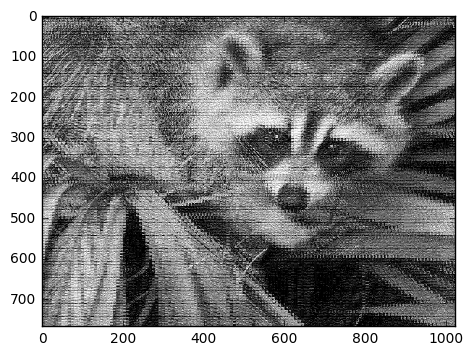

In [266]:
plt.imshow(reconstructed_image, cmap='gray')